# Human Cortical Timescale: ECoG vs. Structural & Transcriptomic Measures
In this notebook, we look at synaptic fluctuation timescales in human cortex across the brain, and through aging, measured via iEEG and ECoG. 

We compare ECoG timescale maps with T1w/T2w map (surrogate for grey matter myelination, and thus, structural hierarchy), as well as postmortem human gene expression maps from the Allen Brain Atlas. All maps are projected onto the HCP-MMP parcellation (Glasser et al., 2016), but only the left side, for 180 parcels in total.

---

ECoG data is taken from the [MNI Open iEEG Atlas (e.g., Frauscher et al., 2018)](https://mni-open-ieegatlas.research.mcgill.ca/). It consists of 1772 channels from 106 patients (~20-65 years old) with varying coverages. The channels are a mixture of surface strip/grid electrodes and stereoEEG electrodes. ECoG electrode coordinates are originally provided in MNI coordinate, and we project them onto HCP-MMP with a simple Gaussian-weighted spatial average (done in ./analysis_collectDF, thanks to Thomas Pfeffer for code inspiration).

T1w/T2w and gene expression maps are very kindly provided by Rudy van den Brink (Tobias Donner lab) and Thomas Pfeffer (previously Donner lab, now Gustavo Deco lab).

All correlations are Spearman's rank correlation, and spatial correlation p-values are computed from resampled null-distributions (by shuffling).

---

### TL;DR:

Spatial correlation analyses follow the same style as Burt et al., 2018. Essentially, after all datasets are in the same spatial reference (HCP-MMP), we look at the rank correlation between timescale, and structural and gene expression variables. It's really quite surprising, but average ECoG timescale derived from 106 patients gathered from several hospitals significantly correlate with average gene expression and GM myelination from completely different cohorts of people, suggesting that it's a conserved property of the human brain. In addition, we see that average ECoG timescale decreases in older subjects, especially in sensorimotor and medial frontal areas.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd
from scipy import io
from scipy.stats import spearmanr, ttest_1samp
from seaborn import despine
from sklearn import decomposition

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

In [182]:
# load parcellation projected ECoG data & structural/transcriptomic data
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural.csv', index_col=1)
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region', 'macro_labels'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# FREE PARAMETER TO JIGGLE!
# patient parcel coverage
w_thres = 0.5
# FREE PARAMETER TO JIGGLE!

df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')

# Patient Coverage in HCP Multi-Modal Parcellation
First we look at the electrode coverage of the entire dataset. Since spatial smoothing of the ECoG timescale is done with a Gaussian (of a defined width) and across the whole brain, all parcels in a single subject will have an interpolated value even if that person only has electrode coverage in one or two parcels.

We don't necessarily want to trust the interpolated value in PFC, for example, if it was smoothed over from the visual cortex. So we apply a threshold to include only parcels where the maximum Gaussian weight (confidence) is above a threshold (0.5 here), which means a parcel is only included for a subject if there was an electrode within some distance (4mm for the Gaussian I used for smoothing if threshold is 0.5).

colormap sequential: [0.00e+00, 1.40e+01, 2.80e+01] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


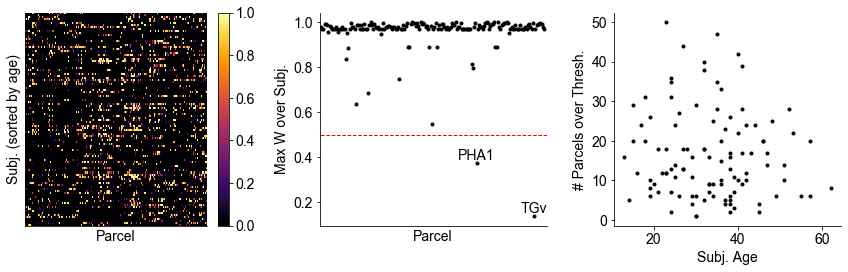

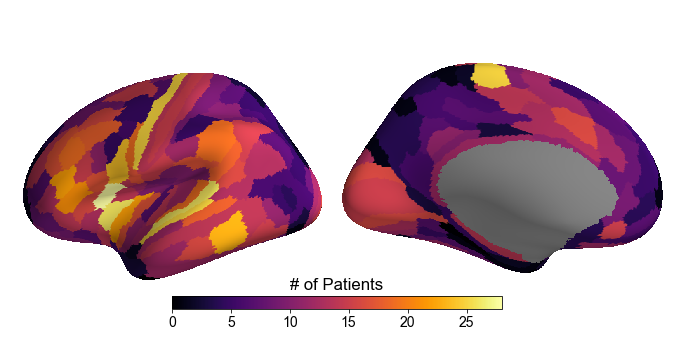

In [3]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'
if plot_subj_coverage:
    # plot aggregate max
    echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate')

    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i'%int(s_i))

# --------
# visualization of thresholded coverage 
plt.figure(figsize=(12,4))

# heat map of weight matrix max (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('Parcel');plt.ylabel('Subj. (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# global maximum weight at each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('Parcel');plt.ylabel('Max W over Subj.')
plt.xticks([]); despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='bottom', horizontalalignment='center')


# of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], df_patient['coverage'],'.k')
plt.xlabel('Subj. Age');plt.ylabel('# Parcels over Thresh.')
despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mni_mmp_coverage')

# number of patients that had coverage at each parcel
parcel_cvg = (df_W_max>=w_thres).sum(axis=0)
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcel_cvg, save_file=fig_path%'mmp_coverage', bp=2, title='# of Patients');

From the above, we see that coverage is quite sparse and idiosyncratic across patients (data matrix in first column). The full data matrix is around 10% populated, but pooling across subjects, most parcels have at least one patient with an electrode very close to it (weight value of >0.9). PHA1 and TGv are the only parcels that do not meet the threshold in even a single patient. The best coverage are in sensorimotor, temporal, and frontal regions (which makes sense for epilepsy localization). Temporal-occipital-parietal junction areas are also not bad, and visual regions are surprisingly well covered.

Also, a few subjects between 25-40 years old have coverages that are much more than normal (>30 parcels), but overall there doesn't seem to be a huge difference in coverage location (data matrix in first column) nor total coverage (third column) across age, which is important to check for the age analysis later on.

# Correlation between Timescale and Structural Measures
In the next set of analyses, we look at the parcel-wise correlation between grand average timescale, and structural heirarchy and also gene expression.

colormap sequential: [1.00e-02, 3.00e-02, 5.00e-02] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


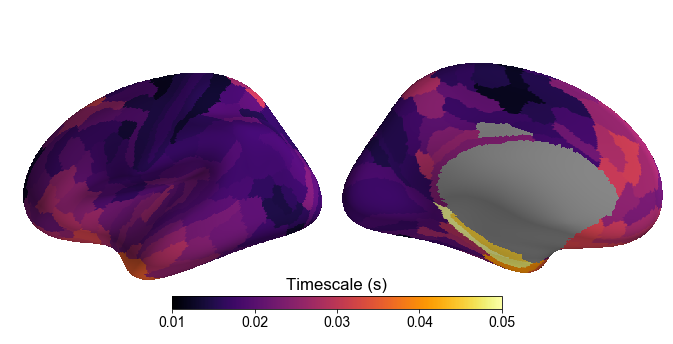

In [4]:
# plot grand average timescale on MMP
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(tau_parcel, save_file=fig_path%'mmp_tau', minmax=[0.01,0.05], bp=2, title='Timescale (s)')

The above visualizes the spatial distribution of ECoG timescales projected onto HCP-MMP. 

Qualitatively, we see that timescale are shorter (faster) in sensory regions (sensorimotor, visual), while frontal (especial medial frontal) and medial temporal/hippocampal regions have longer timescales. 

This is consistent with reports in previous literature, where population timescales increase from sensory to association regions, but for the first time shown here for fast-timescale (synaptic fluctuation) dynamics across the whole human brain.

# Timescale vs. T1wT2w (Structural Hierarchy)

colormap sequential: [1.07e+00, 1.40e+00, 1.72e+00] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


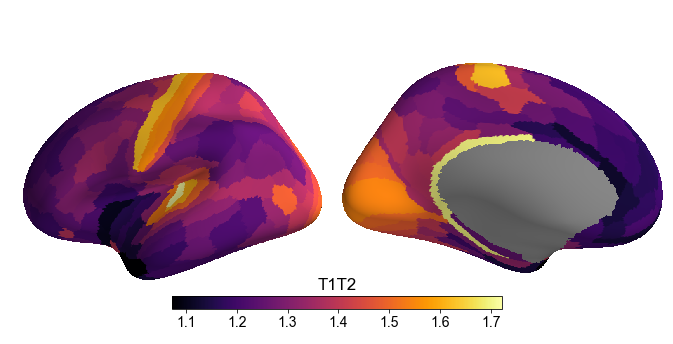

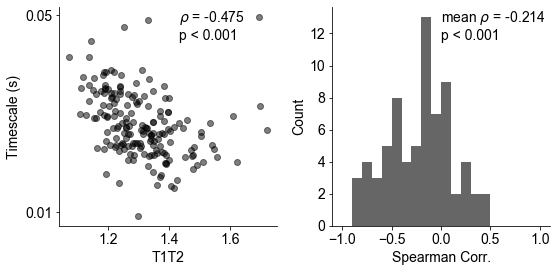

In [84]:
# FREE PARAMETER TO JIGGLE!
# per-subject correlation
min_parcels = 10
# FREE PARAMETER TO JIGGLE!

struct_feat = 'T1T2'
x = df_struct[struct_feat].values
y = tau_parcel

# plot feature on MMP brain
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(x, save_file=fig_path%('mmp_'+struct_feat), bp=2, title=struct_feat)

# group average correlation
rho, pv = spearmanr(df_struct[struct_feat], tau_parcel, nan_policy='omit')
rho, p_est, p_resamp, _ = echo_utils.perm_spearman(x, y, resamp='shuffle')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'ok', alpha=0.5); plt.yscale('log');
plt.xlabel(struct_feat); plt.ylabel('Timescale (s)'); despine()
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)
s = echo_utils.sig_str(rho, p_resamp, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = spearmanr(x, subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)
tt_pv = ttest_1samp(corr_valid, 0)[1]
plt.subplot(1,2,2)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = echo_utils.sig_str(np.nanmean(corr_valid), tt_pv, form='text', corr_letter=r'mean $\rho$')
plt.annotate(s, xy=(0.50, 0.85), xycoords='axes fraction')

plt.tight_layout();
plt.savefig(fig_path[:-4]%('mmp_tau_%s_%i'%(struct_feat,d_query)), bbox_inches='tight')

T1T2 ratio is a measure of gray matter myelination, and has been shown (Burt et al., 2018) to be higher in sensory regions (converging long-range connections) than association regions (local recurrent connections).

Overall, ECoG timescale is significantly and negatively correlated with T1wT2w measurements. This is true on average and at the individual subject level (only subjects with at least min_parcel number of parcels are included). This means areas with higher T1T2 values (higher myelination) have shorter timescales, again suggesting shorter timescale dynamics in primary sensory regions. There are exceptions, however, such as the lone dot in the top right corner, and the neighborhood of datapoints to the middle right (high T1T2, intermediate timescale).

We can also look at this correlation within each subject. Since coverage varies between patients, we set a threshold where a subject is included only if they have at least n number of parcels (10 here). Again, correlations are significantly negative (2-sided 1-sample t-test) but with exceptions.

__In summary, fast synaptic fluctuation timescales measured via human ECoG is significantly correlated with, and may index, anatomical hierarchy, which itself is an index of feedforward vs. recurrent dominant architecture.__

# Timescale vs. Gene Expression

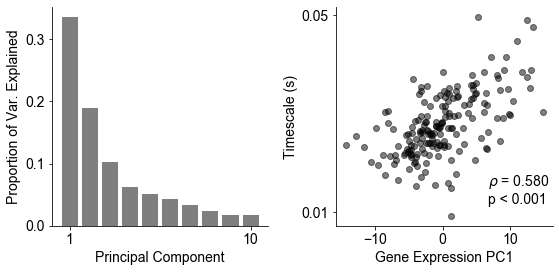

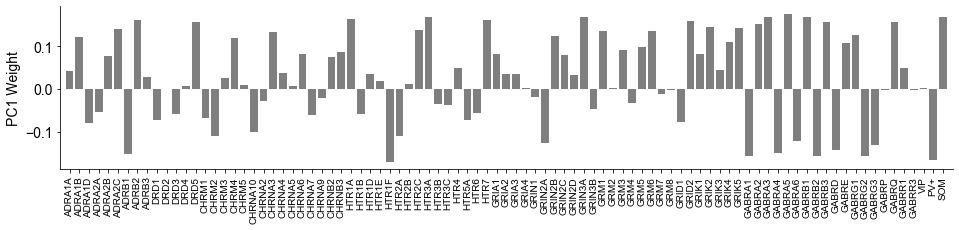

In [173]:
# perform PCA on all genes
n_pcs = 10
gene_pca = decomposition.PCA(n_pcs)
gene_pca.fit(np.array(df_struct)[:,2:])
gene_grad = gene_pca.fit_transform(np.array(df_struct)[:,2:])

x = gene_grad[:,0]
y = tau_parcel.values
rho, _, p_resamp, _ = echo_utils.perm_spearman(x, y, 1000, 'shuffle')

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.bar(range(1,n_pcs+1), gene_pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('Principal Component'); plt.ylabel('Proportion of Var. Explained'); despine();

plt.subplot(1,2,2)
plt.plot(x, y, 'ok', alpha=0.5); plt.yscale('log')
plt.xlabel('Gene Expression PC1'); plt.ylabel('Timescale (s)'); despine()
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(echo_utils.sig_str(rho, p_resamp, form='text'), xy=(0.7,0.1), xycoords='axes fraction');
plt.tight_layout();
plt.savefig(fig_path[:-4]%('mmp_tau_genePC1_%i'%d_query), bbox_inches='tight')

# what are the genes that contribute the most to PC1
# pd.DataFrame(gene_pca.components_[0,:], index=df_struct.columns[2:]).T

pc_weights = pd.DataFrame(gene_pca.components_[0,:], index=df_struct.columns[2:], columns=['weight'])
plt.figure(figsize=(16,3))
plt.bar(range(len(pc_weights)), pc_weights['weight'].values, fc='k', alpha=0.5)
plt.xticks(range(len(pc_weights)), pc_weights.index, rotation=90, fontsize=10);
plt.xlim([-1,len(pc_weights)]); plt.ylabel('PC1 Weight'); despine()
plt.savefig(fig_path[:-4]%('mmp_tau_genePC1_loading_%i'%d_query), bbox_inches='tight')

Following Burt et al., 2018, we look at the (synaptic) gene expression gradient across the cortex altogether via PCA, and compare that with ECoG timescale. The full list of genes can be found in the data table in ../df_structural.csv, and they are the common glutamate and GABA, as well as neuromodulatory synaptic genes, as well as inhibitory cell type (PV, SOM, VIP).

We can see above that timescale is significantly correlated with the dominant gene expression gradient (1st principal component), even more so than with anatomical hierarchy, suggesting a synaptic basis/support for the measured ECoG timescale. Extracellular voltage fluctuations measured via LFP and ECoG are predominantly caused by transmembrane currents, whose timescale depend both on the neuronal integration and synaptic time constants. As such, expression of synapses with longer time constants should coincide with longer ECoG timescale.

In [86]:
# compute correlation of timescale with individual genes
df_tau_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
for i_f, s_f in enumerate(df_struct.columns[1:]):
    rho, _, p_resamp, _ = echo_utils.perm_spearman(df_struct[s_f], tau_parcel.values)    
    df_tau_corr_all.loc[s_f] = rho, p_resamp
    
color = plt.cm.RdBu_r(np.linspace(0,1,200))

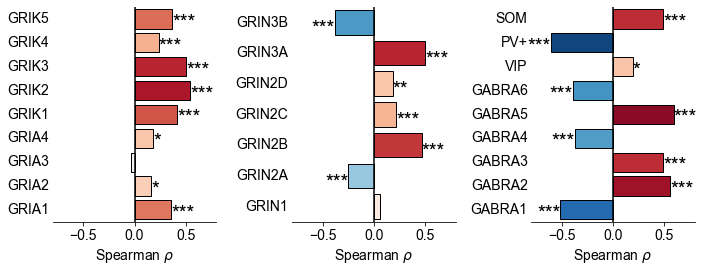

In [87]:
# select a list of genes of interest
expr_ampa = df_tau_corr_all.index[45:49].values
expr_nmda = df_tau_corr_all.index[49:56].values
expr_kainate = df_tau_corr_all.index[66:71].values
expr_gaba = df_tau_corr_all.index[71:77].values
expr_inh = df_tau_corr_all.index[89:92].values

gene_sets = [np.concatenate((expr_ampa, expr_kainate)), expr_nmda, np.concatenate((expr_gaba, expr_inh))]
plt.figure(figsize=(10,4))
for i_g, query_set in enumerate(gene_sets):
    plt.subplot(1,3, i_g+1)
    for i_f, s_f in enumerate(query_set):
        rho, pv = df_tau_corr_all.loc[s_f]
        plt.barh(i_f, rho, ec='k', fc=color[int((1+rho*1.5)*100)])
        s = np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
        plt.text(rho, i_f-0.4, s, fontsize=20, horizontalalignment='left' if rho>0 else 'right')

    plt.plot([0,0], plt.ylim(), 'k')
    plt.ylim([-0.5,len(query_set)-0.5])
    plt.yticks(range(len(query_set)), query_set, rotation=0, ha='right', va='center', rotation_mode='anchor')
    plt.tick_params(axis='y', which=u'both',length=0)
    plt.xlim([-.8,.8]); plt.xlabel(r'Spearman $\rho$')
    despine(left=True);
    

plt.tight_layout()
plt.savefig(fig_path%'mni_gene_indiv',  bbox_inches='tight')

A quick note on this synaptic receptor subunits: synaptic receptors are composed of several subunits, which have isoforms that can be swapped in and out, modulating different aspects of synapse function. For example, "NMDA receptor channels are heterotetramers composed of two molecules of the key receptor subunit NMDAR1 (GRIN1) and two drawn from one or more of the four NMDAR2 subunits: NMDAR2A (GRIN2A), NMDAR2B (GRIN2B), NMDAR2C (GRIN2C), and NMDAR2D (GRIN2D)" (per [Wikipedia](https://en.wikipedia.org/wiki/GRIN2B)).

From the plots above, ECoG timescale is positively and strongly correlated with expression of kainate (GRIK), and less so with AMPA (GRIA) receptor subunits (left plot). AMPA receptors are everywhere in the brain and have very fast rise and decay time constants, so it makes sense for them to be less spatially correlated with ECoG timescales.

Correlation with NMDA subunits expression is more variable: most strongly with GRIN2B, which has been shown to lengthen NMDA activation time constant and improve cognitive function in animals with engineered overexpression. 

In addition, timescales are also strongly correlated with the expression of various forms of GABA receptor alpha subunit, as well as inhibitory cell type markers. Interestingly, timescale is strongly and negatively correlated with PV expression, and positively correlated with SOM expression.

__In summary, fast synaptic fluctuation timescales are also strongly correlated with average gene expression of many synaptic receptor proteins, linking dynamics with its potential structural support. __

---
# Age-Related Changes in Timescale
In the next few sections, we look at the change in ECoG timescale through aging.

### Per-Subject Average Timescale

The ideal analysis here is mixed effects model to jointly estimate the effect of age and hierarchy (with T1T2 as an regressor, e.g.) on tau, but the overall coverage is very poor (10% of total subj x parcel matrix is non-empty) and different across subjects. So we'd have to perform a lot of imputation to fill out that data matrix.

That being the case, we can only look at the average effect across both space (hierarchy) and age, which will confound and/or diminish our estimate of both effects, if there are any. Averaging across subjects for the per-parcel timescale estimate is not too bad, since each parcel has a relatively large sampling of age ranges (see first panel of first figure), and we expect a rather large spatial effect in the first place. 

But averaging across parcels for the per-subject estimate is more strongly biased by the non-uniform coverage of each patient, such that the per-patient timescale estimate essentially comes from a handful of adjacent parcels. Therefore, we need to normalize each tau by the parcel average (or max, or whatever) first before averaging across parcels to remove the spatial effect. Kinda janky, but best I can think of given the sparse sampling problem.

We set a threshold on how many parcels the subject needs to have to be included in this analysis in the first place. Doesn't have to be a large value, since each person usually only has 5-20% coverage (10-30 out of 180).

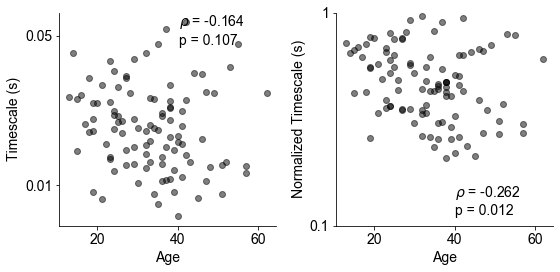

In [193]:
# FREE PARAMETER TO JIGGLE!
# threshold for including subjects if they have at least this many parcels
n_parcel_thresh = 3
# FREE PARAMETER TO JIGGLE!

plt.figure(figsize=(8,4))

# unnormalized averages over parcels per patient
tau_subj = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted', axis=1)
x = df_patient['age'][df_patient['coverage']>=n_parcel_thresh]
y = tau_subj[df_patient['coverage']>=n_parcel_thresh]
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)

plt.subplot(1,2,1)
plt.semilogy(x, y, 'ok', alpha=0.5);
plt.xlabel('Age'); plt.ylabel('Timescale (s)'); despine()
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)

# normalized averages over parcels per patient
df_tau_threshed_parcelnorm = df_tau_threshed/df_tau_threshed.max()
tau_subj_normed = df_tau_threshed_parcelnorm.mean(axis=1)
y = tau_subj_normed[df_patient['coverage']>=n_parcel_thresh]
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')

plt.subplot(1,2,2)
plt.semilogy(x, y, 'ok', alpha=0.5)
plt.xlabel('Age'); plt.ylabel('Normalized Timescale (s)'); despine()
plt.ylim([0.1, 1])
plt.yticks([0.1,1], ['0.1', '1']); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(s, xy=(0.55, 0.05), xycoords='axes fraction')

plt.tight_layout()
plt.savefig(fig_path%'mni_age_overall',  bbox_inches='tight')

The unnormalized per-patient average timescale decreases with age, but the effect is weak. As expected, the parcel-normalized average estimates a much larger effect in the negative correlation between timescale and age. This means that older adults on average have shorter intrinsic timescales as measured via ECoG. Previous reports have reported loss of NMDA receptors (subunit 2B, in particular) in older rats, potentially implicating that as a mechanism of shortened spontaneous dynamics.

### Region Specific Changes in Timescale
The above result shows overall decrease in ECoG timescale when adjusted for region, but is there spatial specificity to the negative correlation between timescale and age? Once again, since coverage is non-uniform across subjects, and is generally sparse and different for each individual region, we can compute a timescale-age correlation for each parcel, but each parcel will have different subjects' data. The following analysis also only includes parcels where there are at least n subjects have data (above the confidence threshold of 0.5).

colormap sequential: [-7.50e-01, 0.00e+00, 7.50e-01] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


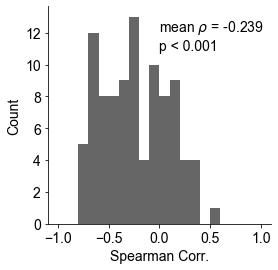

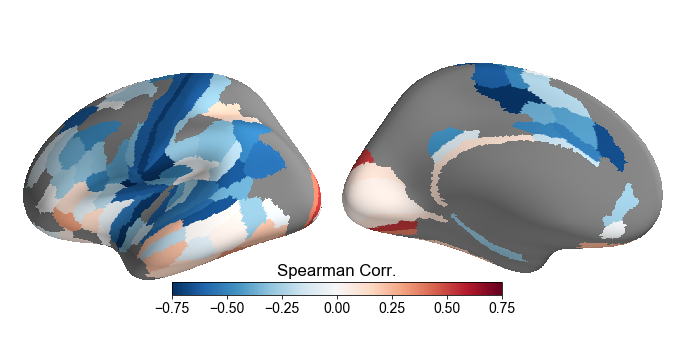

In [90]:
# FREE PARAMETER TO JIGGLE!
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 8
# FREE PARAMETER TO JIGGLE!

# for each parcel, record the number of subjects included, and the spearman rho and p-value
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        # hard threshold of having at least 3 subjects because correlation won't run otherwise
        rho, pv = spearmanr(df_patient['age'], col, nan_policy='omit')
    else:
        # otherwise just fill up with nans
        rho, pv = np.nan, np.nan
    df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
        
# only count correlations from parcels that had min # of subjs, set those that did not meet threshold to nan
parcel_corr = df_age_corr['rho'].astype(float)
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan
x = parcel_corr.values
# t-test on whether parcels have positive or negative correlation in aggregate
tt_pv = ttest_1samp(x, 0, nan_policy='omit')[1]

# plot
plt.figure(figsize=(4,4))
plt.hist(x, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = echo_utils.sig_str(np.nanmean(x), tt_pv, form='text', corr_letter=r'mean $\rho$')
plt.annotate(s, xy=(0.5, 0.8), xycoords='axes fraction')
#plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_dist_%i'%(d_query)), bbox_inches='tight')

# plot spatial distribution of correlation
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(x, fig_path%'mmp_parcel_agecorr', minmax=[-.75,.75], cmap='RdBu_r', title='Spearman Corr.')

From the distribution, we see that across parcels, timescale is on average negatively correlated with age, which agrees with the analysis above. Looking across the cortex, sensorimotor and temporal regions have the largest negative correlations. 

Curiously, visual regions consistently have positively correlations, i.e., timescale increases with age. One potential explanation is the combination of the following: 1) visual regions have high numbers of PV+ interneurons, 2) older adults experience a selective loss of those interneurons, 3) PV expression is negatively correlated with timescale. Therefore, visual regions in older adults should have shorter timescale, but this is a just-so story. The key caveat/assumption here is that **PV expression in a region may not be correlated with its change in expression across aging**.

A similar case can be made for (loss of) NMDA synpases and frontal region decrease in timescale.

### Age-Tau Correlation vs. Gene Expression 
One way to check the above logic is to see if the correlation coefficient within a parcel is then correlated with the expression value of certain genes. Note that this is not quite the ideal thing we want: we would like to see if the age-related expression change of a __single gene__ is correlated with its overall expression at a single region. Assuming gene expression changes contributes to timescale changes (mechanistically, though we've only shown correlations), then we can use timescale as an index for __combined gene expression__. As in, the combined change in expression of many genes gives rise to a __single tau estimate__ at a region.

Nevertheless, we can ask: which genes' expression correlate with, not timescale itself, but the change in timescale across aging.

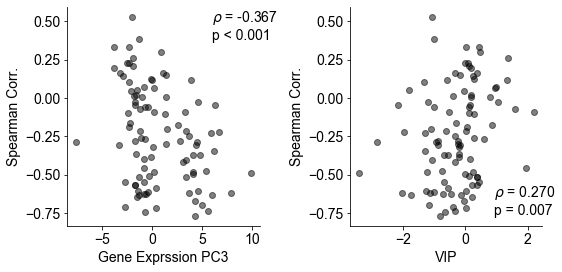

In [171]:
# gene expression vs. tau-age correlation within parcel
plt.figure(figsize=(8,4))

# age-timescale correlation vs. gene expression PCA
x = gene_grad[:,2]
y = parcel_corr.values
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')
plt.subplot(1,2,1)
plt.plot(x, y, 'ok', alpha=0.5)
plt.xlabel('Gene Exprssion PC3'); plt.ylabel('Spearman Corr.'); despine()
plt.annotate(s, xy=(0.75, 0.85), xycoords='axes fraction');

# age-time scale correlation vs. a single gene
struct_feat = 'VIP'
x = df_struct[struct_feat].values
y = parcel_corr.values
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')

plt.subplot(1,2,2)
plt.plot(x, y, 'ok', alpha=0.5)
plt.xlabel(struct_feat); plt.ylabel('Spearman Corr.'); despine()
plt.annotate(s, xy=(0.75, 0.05), xycoords='axes fraction');
plt.tight_layout()

plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_meta_%i'%(d_query)), bbox_inches='tight')

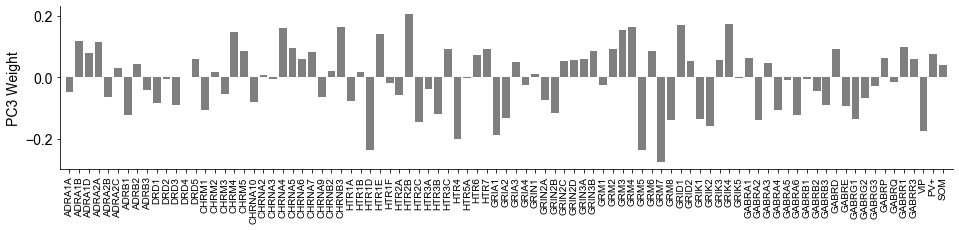

In [163]:
pc_weights = pd.DataFrame(gene_pca.components_[2,:], index=df_struct.columns[2:], columns=['weight'])
plt.figure(figsize=(16,3))
plt.bar(range(len(pc_weights)), pc_weights['weight'].values, fc='k', alpha=0.5)
plt.xticks(range(len(pc_weights)), pc_weights.index, rotation=90, fontsize=10);
plt.xlim([-1,len(pc_weights)]); plt.ylabel('PC3 Weight'); despine()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_metaPC3_%i'%(d_query)), bbox_inches='tight')

Of the top 10 gene expression principal components, the 3rd PC is significantly correlated with the age-timescale correlation. If we look at the genes with a high loading in the 3rd PC (bar plot), we see a lot of _modulatory_ (e.g., HTR1D) and slow-acting metabotropic (e.g, GRM7) synaptic genes, as well as VIP expression. Plotting the correlation of those individual genes with high loading against the age-timescale correlation will, of course, yield significant correlations (VIP as an example above).

I'm not exactly sure how to make sense of this?

---
# Pool into 21 Glasser Macro Regions
This section repeats the key analyses from above, but with the 22 macro regions found in Glasser et al., 2018 Supplemental, so we can visualize (label) to see if any regions stand out. V1 parcel had its own group so I lumped it with "early visual" (hence 21 regions). All parcels within a macro region are then averaged, both for timescale and structural measures.

In [185]:
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
for i_r, r in mmp_aggr.groupby('macro_labels'):
    df_tau_macro[i_r] = echo_utils.compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[r['parcel']].mean(axis=0)
    
df_struct_macro = df_struct_macro.T
df_tau_macro_mean = df_tau_macro.mean(0)

### Spatial Correlation with T1wT2w and Gene Expression

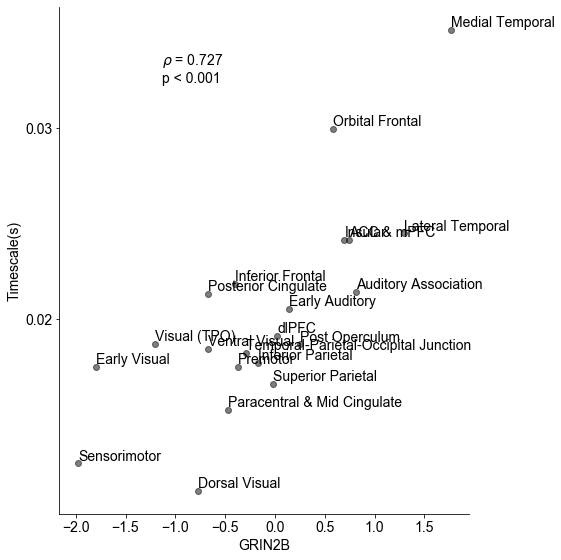

In [206]:
struct_feat = 'GRIN2B'
plt.figure(figsize=(8,8))
x = df_struct_macro[struct_feat]
y = df_tau_macro_mean

plt.plot(x,y, 'ok', alpha=0.5)
for mr in df_struct_macro.index:
    plt.annotate(mr, (df_struct_macro.loc[mr][struct_feat], df_tau_macro_mean[mr]), 
                 horizontalalignment='left', verticalalignment='bottom', fontsize=14)
    
plt.yscale('log'); 
plt.xlabel(struct_feat); plt.ylabel('Timescale(s)');despine()
plt.yticks([0.02, 0.03], ['0.02', '0.03']);

spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.25, 0.85), xycoords='axes fraction');
plt.tight_layout()

Macro region correlations between timescale and structural variables are even stronger, exemplified by the above for GRIN2B (also try PV+). As expected, early sensory regions (visual, primary sensory/motor) have very short timescales, while association regions (medial temporal, frontal) have longer timescales. 

### Age Correlation per Region

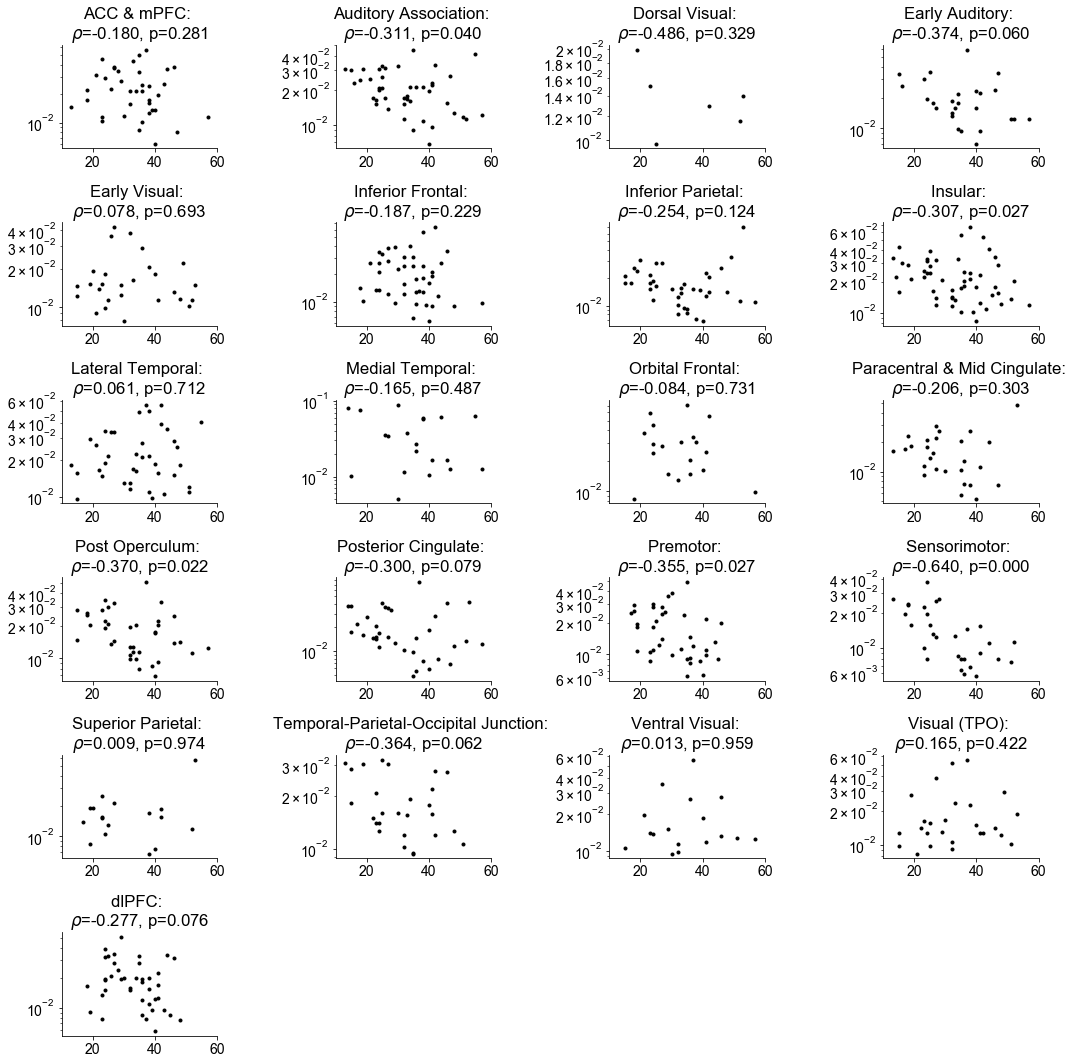

In [223]:
plt.figure(figsize=(15,15))
for i_r, r in enumerate(df_tau_macro.columns):
    plt.subplot(6,4,i_r+1)
    plt.semilogy(df_patient['age'], df_tau_macro[r], '.k')
    rho,pv = spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
    plt.tick_params(axis='y', which='both', left='off', labelleft='off')
#    plt.yscale('log')
#    plt.yticks([]);

    plt.xlim([10,60]); despine()
    
    plt.title('%s: \n'%r + r'$\rho$=%.3f, p=%.3f'%(rho,pv))

plt.tight_layout()

Again, timescale-age correlations are consistently negative, but differ in strength across areas. Sensorimotor and premotor have the strongest effects, while visual areas are again (slightly) positive.